# Coloring a random graph using Belief Propagation

Given a graph $G=(V,E)$ and an integer $q$, a valid coloring is an assignment mapping each vertex in $G$ to a color (i.e. an integer in $\{1,2,\ldots,q\}$) such that no edge connects two nodes with the same color.
One way to solve the problem is to write a probability distribution over all the possible assignments giving non-zero weights to the valid ones, zero otherwise
$$p(x)\propto \prod_{(ij)\in E}\left[1-\delta(x_i,x_j)\right]$$
which is then approximated via BP.

In [1]:
using Graphs, IndexedGraphs, IndexedFactorGraphs
using BeliefPropagation, BeliefPropagation.Models
using Random
using GraphRecipes, Plots

In [2]:
# try to find a valid coloring using BP
function try_coloring(g::IndexedGraph, q::Integer; 
        maxiter=100, tol=1e-8, damp=0.5, rein=1e-2)
    N = nv(g)
    gp = pairwise_interaction_graph(g)
    ψ = fill(ColoringCoupling(), ne(g))
    # a small symmetry-breaking vertex prior
    ϕ = map(1:N) do i
        ϕᵢ = exp.(1e-6*randn(MersenneTwister(seed), q))
        BPFactor(ϕᵢ)
    end
    states = fill(q, N)
    bp = BP(gp, ψ, states; ϕ)
    iterate!(bp; maxiter, tol, damp, rein)
    x = argmax.(beliefs(bp))
    return x
end

# compute the number of monochromatic edges, i.e. those with
#  the same color at both ends
function n_monochromatic(x, g::IndexedGraph)
    en = 0
    for e in edges(g)
        i = src(e); j = dst(e)
        en += x[i] == x[j]
    end
    return en
end

function is_valid_coloring(x, g::IndexedGraph)
    return n_monochromatic(x, g) == 0
end

is_valid_coloring (generic function with 1 method)

In [3]:
q = 3
N = 30
c = 2.5
seed = 1

# Sample a random graph and keep only the largest connected component
gg = erdos_renyi(N, round(Int, N*c/2); seed)
cc = first(connected_components(gg))
A = adjacency_matrix(gg)[cc,cc]
g = IndexedGraph(A)

maxiter = 10^3
tol = 1e-8
damp = 0.5
rein = 1e-2

# reinforcement is used to bias BP to a single one out of the many
#  possible solutions
x = try_coloring(g, q; maxiter, tol, damp, rein)
is_valid_coloring(x, g)

true

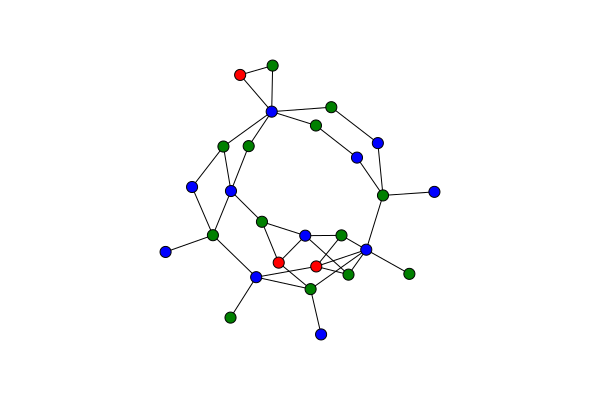

In [4]:
colors = [:red, :green, :blue]

graphplot(
    g,
    curves = false,
    nodecolor = [colors[i] for i in x],
    markersize = 0.15,
    nodeshape = :circle
)